### Overview

The following notebook contains basic examples of the functionalities implemented in neuroLang in order to determine relative positioning of brain regions. 

In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if 'module_path' not in sys.path:
    sys.path.append(module_path)

from IPython.display import display
import numpy as np
import nibabel as nib
from nilearn import plotting
import neurolang as nl
from typing import AbstractSet, Callable
from neurolang.CD_relations import *
from neurolang.frontend import *
from neurolang.regions import *
from neurolang.region_solver import *
from neurolang.symbols_and_types import TypedSymbolTable, is_subtype, Constant, Predicate, Query, Symbol

%matplotlib inline

The first thing we will do is to load the cortical gyri and sulci parcellation defined in [Destrieux et al. (2010)](https://dx.doi.org/10.1016%2Fj.neuroimage.2010.06.010), for one subject we will get both the full T1w image and the labeled parcellation and store them as ``Nifti1Image``s using nibabel.

In [2]:
subject = '100206'
t1w_path = f'../data/{subject}/T1w/T1w_acpc_dc_restore_brain.nii.gz'
labels_path = f'../data/{subject}/T1w/aparc.a2009s+aseg.nii.gz'
labeled_im = nib.load(labels_path)
t1w_im = nib.load(t1w_path)
type(t1w_im)

nibabel.nifti1.Nifti1Image

Next, we want to extract the relevant data from the images that are useful to define our abstraction of each region. We are going to have an instance of the query solver in charge of handling the data and storing it into the symbol table. The ``load_parcellation_regions_to_solver`` method is going to get the voxels of each of the labeled regions from the parcellation image and store them as different objects identifiable by their label name.    

In [3]:
neurolang = RegionFrontend()
rois = {'CTX_RH_S_CIRCULAR_INSULA_INF', 'CTX_LH_LAT_FIS-POST', 'CTX_LH_G_FRONT_MIDDLE'}
regions = neurolang.load_parcellation(labeled_im, selected_labels=rois)
len(regions)

3

In [4]:
neurolang.functions

['inferior_of',
 'converse inferior_of',
 'superior_of',
 'converse superior_of',
 'posterior_of',
 'converse posterior_of',
 'anterior_of',
 'converse anterior_of',
 'overlapping',
 'converse overlapping',
 'left_of',
 'converse left_of',
 'right_of',
 'converse right_of',
 'universal',
 'neurosynth_term',
 'regexp']

In [5]:
neurolang.region_names

['CTX_LH_G_FRONT_MIDDLE',
 'CTX_LH_LAT_FIS-POST',
 'CTX_RH_S_CIRCULAR_INSULA_INF']

Aditional to this, I'm giving a function to store a specific region in the symbol table given it's label. This can be useful to work with certain parts of the parcellation and reduce the search space when performing a query.

Each of the regions is abstracted into an instance of ```ExplicitVBR``` that stores the list of voxels, affine matrix and bounding box enclosing the region. Most of the operations between regions consider the spatial values of it's bounding box, which obviously brings innacuracy given the fact that each bounding box is a 3-dimensional hyperrectangle that don't do justice to all the possible complex shapes of brain areas. A solution to this is to cover the region with fixed-size bounding boxes and operate between them at the most convenient level of resolution. 

Now that we have a set of them in memory I'm going to focus on a particular region of interest. The class has a method to generate a spatialImage suitable for integration with NiBabel plotting methods.

In [6]:
neurolang.load_parcellation(labeled_im, selected_labels=('CTX_RH_G_AND_S_SUBCENTRAL'))
subcentral_g_and_s = neurolang.get_symbol('CTX_RH_G_AND_S_SUBCENTRAL')
type(subcentral_g_and_s)

neurolang.frontend.query_resolution.QueryBuilderSymbol

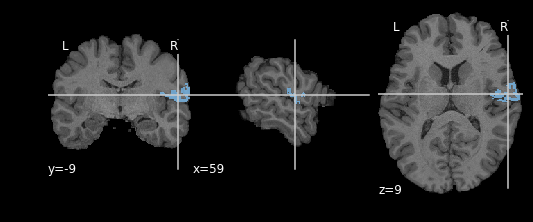

In [7]:
img = region_union(subcentral_g_and_s.value).spatial_image()
plotting.plot_roi(img, t1w_im, cmap=plotting.cm.cyan_copper) 

With that in mind the first thing to do is to define the predicate statement we want the query to solve, one example of this could be obtaning all regions in our base of knowledge that are superior to our region of interest, the subcentral gyrus and sulcus.

The method ``define_predicate`` does that and given the fact that we consider binary relations between the reference region and the rest, those are the parameters, the relation and the reference region.  

Up to this point the posible values for directions are *inferior_of, superior_of, posterior_of, anterior_of, left_of, right_of and overlapping*

In [8]:
sup = neurolang.define_predicate('superior_of',  subcentral_g_and_s)
inf = neurolang.define_predicate('inferior_of',  subcentral_g_and_s)
both = sup & ~inf

To execute the query just pass the predicate to solve and an optional parameter to specify the symbol name of the result:

In [9]:
result_sup = neurolang.solve_query(
    sup,
    result_symbol_name='superior_rh_subcentral'
)
result_sup

superior_rh_subcentral: typing.AbstractSet[neurolang.regions.Region] = ['CTX_LH_LAT_FIS-POST', 'CTX_LH_G_FRONT_MIDDLE', 'CTX_RH_S_CIRCULAR_INSULA_INF']

Algebraic operations (union, intersection and difference) between regions are implemented for `ExplicitVBR` to compose them based on their voxels , for example to group the obtained result:

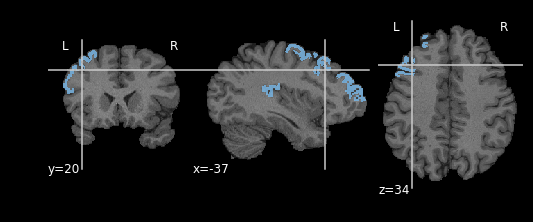

In [10]:
result_region = region_union(result_sup.value)
plotting.plot_roi(result_region.spatial_image(), t1w_im, cmap=plotting.cm.cyan_copper)

In [11]:
result_inf = neurolang.solve_query(inf)

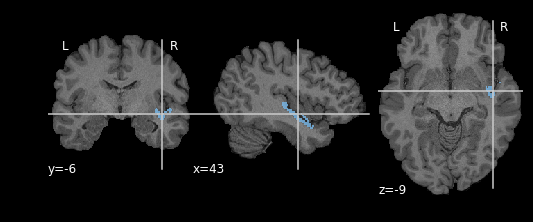

In [12]:
result_inf = neurolang.solve_query(inf)
region_inf = region_union(result_inf.value)
plotting.plot_roi(region_inf.spatial_image(), t1w_im, cmap=plotting.cm.cyan_copper)

Aside from manipulating explicit regions given the list of voxels and the affine matrix regions can be defined by an implicit object that characterize the world coordinates it contains, so far we have two, which are subclasses of ``ImplicitVBR``:

* ``SphericalVolume``: Which creates a sphere based on a given coordinate center and radius.


* ``PlanarVolume``: Which defines a plane given a origin point in the space and a normal vector perpendicular to all the points in it. The plane splits the space in two regions, so the volume of coordinates that we are going to consider for the region must be specified with a parameter indicating the direction, if it's 1 the region will contain all coordinates above the plane, if it's -1 otherwise.

All instances of ``ImplicitVBR`` can be converted to explicit ones by the method ``to_explicit_vbr`` that takes the affine matrix of the voxel space and the image shape for plotting as a parameters. 

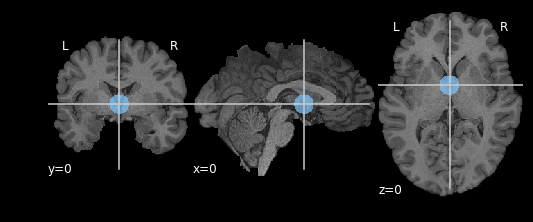

In [13]:
sphere = SphericalVolume((0,0,0), 10)
explicit_sphere = sphere.to_explicit_vbr(t1w_im._affine, t1w_im.shape)
plotting.plot_roi(explicit_sphere.spatial_image(), t1w_im, cmap=plotting.cm.cyan_copper)

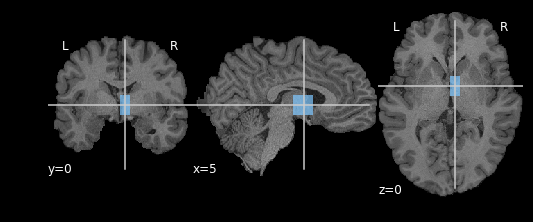

In [14]:
plane = PlanarVolume(origin=(0,0,0), vector=(1,0,0), limit=10)
explicit_plane = plane.to_explicit_vbr(t1w_im._affine, t1w_im.shape)
plotting.plot_roi(explicit_plane.spatial_image(), t1w_im, cmap=plotting.cm.cyan_copper)

In [15]:
origin_sphere = neurolang.add_region(sphere, 'origin_sphere')

In [16]:
inf_sphere = neurolang.solve_query(neurolang.define_predicate('inferior_of', origin_sphere))
inf_sphere

09a5365e-8048-11e8-a4a4-8cec4bfc2fdd: typing.AbstractSet[neurolang.regions.Region] = ['CTX_RH_S_CIRCULAR_INSULA_INF', '02ad4f62-8048-11e8-a4a4-8cec4bfc2fdd', '02ad4f63-8048-11e8-a4a4-8cec4bfc2fdd', '09a5365e-8048-11e8-a4a4-8cec4bfc2fdd']

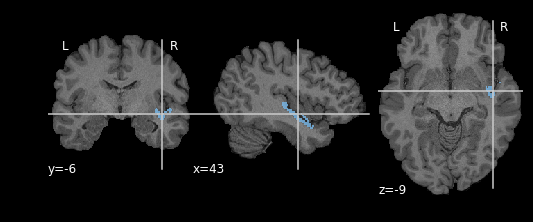

In [17]:
plotting.plot_roi(region_union(inf_sphere.value).spatial_image(), t1w_im, cmap=plotting.cm.cyan_copper)